In [1]:
images = []
lesions = []
from skimage.io import imread
import os
root = './PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [2]:
from skimage.transform import resize

size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False,) > 0.5 for y in lesions]
print(f'Loaded {len(X)} images')

Loaded 200 images


In [3]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)

In [4]:
ix = np.random.choice(len(X), len(X), False)
train, val, test = np.split(ix, [100, 150])

In [5]:
from torch.utils.data import DataLoader
batch_size = 15

data_train = DataLoader(list(zip(np.rollaxis(X[train], 3, 1), Y[train, np.newaxis])), batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])), batch_size=batch_size, shuffle=True)
data_test = DataLoader(list(zip(np.rollaxis(X[test], 3, 1), Y[test, np.newaxis])), batch_size=batch_size, shuffle=False)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim

import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [7]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.dec_conv0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):

        dim_0 = x.size()
        e0 = self.enc_conv0(x)
        e0, indices_1 = F.max_pool2d(e0, kernel_size=2, stride=2, return_indices=True)

        dim_1 = e0.size()
        e1 = self.enc_conv1(e0)
        e1, indices_2 = F.max_pool2d(e1, kernel_size=2, stride=2, return_indices=True)

        dim_2 = e1.size()
        e2 = self.enc_conv2(e1)
        e2, indices_3 = F.max_pool2d(e2, kernel_size=2, stride=2, return_indices=True)

        dim_3 = e2.size()
        e3 = self.enc_conv3(e2)
        e3, indices_4 = F.max_pool2d(e3, kernel_size=2, stride=2, return_indices=True)

        b = self.bottleneck_conv(e3)
        # b = self.bottleneck_conv(b)

        upsampling1 = F.max_unpool2d(b, indices_4, kernel_size=2, stride=2, output_size=dim_3)
        d0 = self.dec_conv0(upsampling1)

        upsampling2 = F.max_unpool2d(d0, indices_3, kernel_size=2, stride=2, output_size=dim_2)
        d1 = self.dec_conv1(upsampling2)

        upsampling3 = F.max_unpool2d(d1, indices_2, kernel_size=2, stride=2, output_size=dim_1)
        d2 = self.dec_conv2(upsampling3)

        upsampling4 = F.max_unpool2d(d2, indices_1, kernel_size=2, stride=2)
        d3 = self.dec_conv3(upsampling4)

        # output = F.softmax(d3, dim=1)

        return d3

In [18]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.1), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded

In [9]:
def bce_loss(y_real, y_pred):
    y_real, y_pred = y_real.cpu(), y_pred.cpu()
    y_real, y_pred = y_real.detach().numpy(), y_pred.detach().numpy()
    res = y_pred - (y_real * y_pred) + np.log(1 + np.exp(- y_pred))
    res = torch.from_numpy(res)
    res.requires_grad = True
    return res

In [10]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch)
            loss.backward()
            opt.step()

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device))    # detach and put into cpu
        Y_hat = Y_hat.cpu()
        Y_hat = Y_hat.detach().numpy()

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

In [11]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [12]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

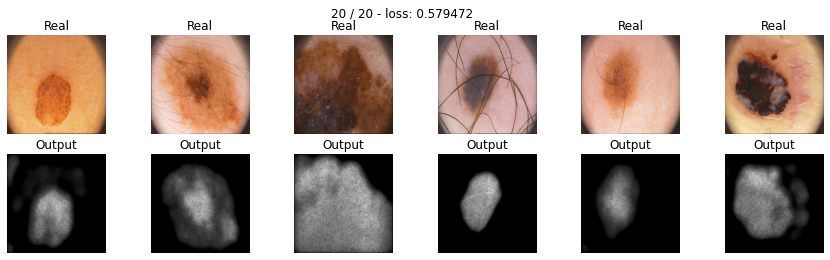

In [13]:
model = SegNet().to(device)

max_epochs = 20
optim = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.BCEWithLogitsLoss()
train(model, optim, loss_fn, max_epochs, data_train, data_val)

In [14]:
torch.cuda.memory.empty_cache()

In [19]:
score_model(model, iou_pytorch, data_val)

C:\Users\Pack\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.13166667520999908